In [1]:
from SeismicReduction import *
import pickle

In [2]:
def train(epoch, model, optimizer, train_loader, beta=1, recon_loss_method='mse'):
    """
    Trains a single epoch of the vae model.

    Parameters
    ----------
    epoch : int
        epoch number being trained
    model : torch.nn.module
        model being trained, here a vae
    optimizer : torch.optim
        optmizer used to train model
    train_loader : torch.utils.data.DataLoader
        data loader used for training
    beta : float
        beta parameter for the beta-vae
    recon_loss_method : str
        specifies the reconstruction loss technique

    Returns
    -------
    trains the model and returns training loss for the epoch

    """
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)

        optimizer.zero_grad()
        
        recon_batch, mu, logvar, _ = model(data)
        loss = loss_function(recon_batch,
                             data,
                             mu,
                             logvar,
                             window_size=data.shape[-1],
                             beta=beta,
                             recon_loss_method=recon_loss_method)
        # print('batch:', batch_idx, 'loss:', loss.item())
        loss.backward()

        # 'loss' is the SUM of all vector to vector losses in batch
        train_loss += loss.item()  # * data.size(0)  # originally

#         print('batch:', batch_idx, 'to add to total:', loss.item())
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    # print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss), len(train_loader.dataset))
    return train_loss

In [31]:
class VaeModel(ModelAgent):
    """
    Runs the VAE model to reduce the seismic data to an arbitrary sized dimension, visualised in 2 via UMAP.
    """
    def __init__(self, data):
        super().__init__(data)
        self.name = 'VAE'

    def create_dataloader(self, test_size=0.5, batch_size=32):
        """
        Create pytorch data loaders for use in vae training, testing and running.

        Parameters
        ----------
        batch_size : int
            Size of data loader batches.

        Returns
        -------
        Modifies object data loader attributes.

        """
        # create torch tensor
        assert self.input.shape[1] == 2, 'Expected a three dimensional input with 2 channels'
        X = torch.from_numpy(self.input).float()

        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

        split = ShuffleSplit(n_splits=1, test_size=test_size)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
        print('train size:', X_train.size(), 'test size:', X_test.size())
              
        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset,
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset,
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      **kwargs)

    def train_vae(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse'):
        """
        Handles the training of the vae model.

        Parameters
        ----------
        epochs : int
            Number of complete passes over the whole training set.
        hidden_size : int
            Size of the latent space of the vae.
        lr : float.
            Learning rate for the vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation

        Returns
        -------
        None

        """
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size,
                         self.input.shape)  # Inititalize the model

        optimizer = optim.Adam(self.model.parameters(),
                               lr=lr,
                               betas=(0.9, 0.999))
    


        if self.plot_loss:
            liveloss = PlotLosses()
            liveloss.skip_first = 0
            liveloss.figsize = (16, 10)

        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch, self.model, optimizer, self.train_loader, recon_loss_method=recon_loss_method)  # Train model on train dataset
            
            testl = test(epoch, self.model, self.test_loader, recon_loss_method=recon_loss_method)

            if self.plot_loss:  # log train and test losses for dynamic plot
                logs = {}
                logs['' + 'ELBO'] = tl
                logs['val_' + 'ELBO'] = testl
                liveloss.update(logs)
                liveloss.draw()
                
        return testl

    def run_vae(self):
        """
        Run the full data set through the trained vae model.

        Returns
        -------
        Modifies the zs attribute, an array of shape (number_traces, latent_space)
        """
        _, zs = forward_all(self.model, self.all_loader)
        return zs.numpy()

    def reduce(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse', plot_loss=True, test_size=0.5):
        """
        Controller function for the vae model.

        Parameters
        ----------
        epochs : int
            Number of epochs to run vae model.
        hidden_size : int
            Size of the vae model latent space representation.
        lr : float
            Learning rate for vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation
        plot_loss : bool
            Control on whether to plot the loss on vae training.

        Returns
        -------
        Modifies embedding attribute via generation of the low dimensional representation.

        """
        if hidden_size < 2:
            raise Exception('Please use hidden size > 1')

        self.plot_loss = plot_loss  # define whether to plot training losses or not
        self.create_dataloader(test_size=test_size)

        if not self.loaded_model:
            loss = self.train_vae(epochs=epochs, hidden_size=hidden_size, lr=lr, recon_loss_method=recon_loss_method)

        self.embedding = self.run_vae()  # arbitrary dimension output from VAE
        
        return loss

In [32]:
# load data
file_pi2 = open('./pickled/data.pickle', 'rb')
dataholder = pickle.load(file_pi2)
file_pi2.close()

In [33]:
### Processor
processor = Processor(dataholder)
input1 = processor(flatten=[True, 12, 52], normalise=True)

Processor has created an output with shape:  (25351, 2, 64)


In [34]:
vae = VaeModel(input1)

ModelAgent initialised


# Train/test split:

In [90]:
test_splits = [1 - 10**(i-4) for i in range(4)]
test_splits += [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.001]
print(test_splits)
test_split_losses = []

for i in test_splits:
    test_size = i
    loss = vae.reduce(epochs=150, hidden_size=8, lr=0.01, plot_loss=False, test_size=test_size)
    print('test split size', i, 'loss:', loss)
    test_split_losses.append(loss)

[0.9999, 0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.001]
train size: torch.Size([2, 2, 64]) test size: torch.Size([25349, 2, 64])


/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


test split size 0.9999 loss: 157.37009683201416
train size: torch.Size([25, 2, 64]) test size: torch.Size([25326, 2, 64])
test split size 0.999 loss: 178.1502227554255
train size: torch.Size([253, 2, 64]) test size: torch.Size([25098, 2, 64])
test split size 0.99 loss: 127.27356688052366
train size: torch.Size([2535, 2, 64]) test size: torch.Size([22816, 2, 64])
test split size 0.9 loss: 103.963649701604
train size: torch.Size([5070, 2, 64]) test size: torch.Size([20281, 2, 64])
test split size 0.8 loss: 129.26425478617224
train size: torch.Size([7605, 2, 64]) test size: torch.Size([17746, 2, 64])
test split size 0.7 loss: 100.50246317061767
train size: torch.Size([10140, 2, 64]) test size: torch.Size([15211, 2, 64])
test split size 0.6 loss: 127.24309726931014
train size: torch.Size([12675, 2, 64]) test size: torch.Size([12676, 2, 64])
test split size 0.5 loss: 102.99174634813699
train size: torch.Size([15210, 2, 64]) test size: torch.Size([10141, 2, 64])
test split size 0.4 loss: 95.

In [91]:
print(test_split_losses)

[157.37009683201416, 178.1502227554255, 127.27356688052366, 103.963649701604, 129.26425478617224, 100.50246317061767, 127.24309726931014, 102.99174634813699, 95.66563452391591, 100.11785360652775, 96.3677935907766, 99.47336566335396, 86.45413912259616]


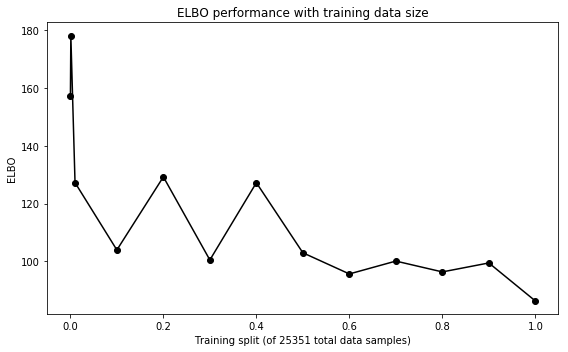

In [94]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot([(1-i) for i in test_splits], test_split_losses, marker='o', color='black')
ax.set_title('ELBO performance with training data size')
ax.set_ylabel('ELBO')
ax.set_xlabel('Training split (of 25351 total data samples)')
fig.tight_layout()